In [2]:
# !pip install numpy==1.21.6
# !pip install matplotlib==3.5.3
# !pip install pandas==1.3.5
# !pip install scipy==1.7.3
# !pip install plotly==5.18.0
# !pip install scikit-learn==1.0.1
# !pip install tensorflow==2.11.0
# !pip install sciann==0.7.0.1

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import tensorflow as tf
from sciann import Functional, Variable, SciModel, PDE
from sciann.utils import *
import scipy.io
import time
import random
import os 
import filtf as ff
from my_window import my_window

/home/andrei/Downloads/Code/ConcreteModelPINN/.venv/lib/python3.7/site-packages/pandas/compat/__init__.py:124: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)
2024-09-08 10:55:19.927855: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-08 10:55:20.045822: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-08 10:55:20.050508: W tensorflow/compiler/xla/stream_executor/pla

---------------------- SCIANN 0.7.0.1 ---------------------- 
For details, check out our review paper and the documentation at: 
 +  "https://www.sciencedirect.com/science/article/pii/S0045782520307374", 
 +  "https://arxiv.org/abs/2005.08803", 
 +  "https://www.sciann.com". 

 Need support or would like to contribute, please join sciann`s slack group: 
 +  "https://join.slack.com/t/sciann/shared_invite/zt-ne1f5jlx-k_dY8RGo3ZreDXwz0f~CeA" 
 
TensorFlow Version: 2.11.0 
Python Version: 3.7.9 (default, Aug 29 2024, 22:22:50) 
[GCC 13.2.0] 



In [4]:
np.random.seed(123)
tf.random.set_seed(123)

# Model Specification

In [5]:
# Space parameters
nx, nz = 240, 240
dx, dz = 0.01, 0.01
x = np.arange(0, nx*dx, dx)
z = np.arange(0, nz*dz, dz)

pad = 10
center = [nz / 2, nx / 2] # center of velmodel 
x0 = nx / 2 * dx
z0 = nz / 2 * dz # x and z coordinates of the center of the velmodel
radius = 1

r = 1.83/2 # radius of smaller circular region
n = 8 # number of receivers and sources
tet = np.linspace(-np.pi, np.pi, n+1) # array of angles for placing the points around the circle
xi = r * np.cos(tet) + x0 # x-coordinates of sources and receivers
zi = r * np.sin(tet) + z0 # z-coordinates of sources and receivers

xi = xi[:-1] 
zi = zi[:-1] # Remove last element of the array

In [23]:
print(xi)

[0.285     0.5529973 1.2       1.8470027 2.115     1.8470027 1.2
 0.5529973]


# Source location

In [6]:
sx = np.round(xi / dx).astype(int) # x-coordinates of sources and receivers in grid points
sz = np.round(zi / dz).astype(int) # z-coordinates of sources and receivers in grid points
Ns = len(sx) # number of sources
s = [sz.T, sx.T] # source and receiver coordinates

# Receiver positions

In [7]:
# When using one sources, others are receivers

rx = sx
rz = sz
r = s
Nr = len(rx) # number of receivers

# Source-Receiver distances

In [8]:
distances = np.zeros((Nr, Ns))
for i in range(1, Ns):
    distances[i, :] = np.sqrt((rx - sx[i]) ** 2 * dx**2 + (rz - sz[i])**2 * dz**2)


# Time parameters of observed data

In [9]:
tmax = 1/1000
dts = 1/500000
ts = np.arange(0, tmax + dts, dts) # time axis
nts = len(ts)

# Filtering and normalizing the data

In [10]:
laplacian = 2

filt = [20000, 30000, 60000, 70000]

fmin = [filt[1], filt[1] - filt[0]]
fmax = [filt[2], filt[3] - filt[2]]
phase = 0
max_atten = 80 # maximum attenuation in dB

# Windowing

In [11]:
t01 = 0.1/1000
t02 = 0.4/1000

V0 = 4000

# Source as a Ricker Wavelet
fc = 50000
t0 = 0 * tmax
depth = 1005

# Reference receiver for sources

In [12]:
RR = np.zeros((nts, Nr, Ns))

# Loop over sources (i) and receivers (j)

for i in range(Ns):
    for j in range(2, Nr):

        if j > i:
            # Read CSV file based on i,j
            level = pd.read_csv(f'data/TP3-5.{i+1}{j+1}.CSV', usecols=[0], skiprows=3, nrows=nts).values.flatten()
            row = np.argmin(np.abs(level - depth)) # Find closet row based on depth
            data1 = pd.read_csv(f'data/TP3-5.{i+1}{j+1}.CSV', usecols=range(8, 508), skiprows=row+3, nrows=1).values
            
        elif j < i:
            # Read CSV file based on j,i
            evel = pd.read_csv(f'data/TP3-5.{j+1}{i+1}.CSV', usecols=[0], skiprows=3, nrows=nts).values.flatten()
            row = np.argmin(np.abs(level - depth)) # Find closet row based on depth
            data1 = pd.read_csv(f'data/TP3-5.{j+1}{i+1}.CSV', usecols=range(8, 508), skiprows=row+3, nrows=1).values
        else:
            # i == j, assign zeros
            data1 = np.zeros((nts, 1))

        data1 = data1.flatten()
        data = np.concatenate((np.zeros((int(np.ceil(t0 / dts)), )), data1))
        
        if data.shape[0] > nts:
            data = data[nts:, :]
        else:
            data = np.pad(data, ((0, nts - data.shape[0])))
            
        RR[:, j, i] = data

# Filtering and normalizing the data

In [13]:
for i in range(Ns):
    R_ii = np.zeros((nts, Nr))
    data = np.squeeze(RR[:, :, i])
    for j in range(Nr):
        if distances[i, j] == 0:
            data[:, j] = 0
        else:
            R_ii[:, j] = ff.filtf(data[:, j], ts, fmin, fmax, phase, max_atten)
            
    R_ii = my_window(R_ii, dts, t01, t02, distances[i, :], V0)
RR[:, :, i] = R_ii

/home/andrei/Downloads/Code/ConcreteModelPINN/my_window.py:48: RuntimeWarning: invalid value encountered in true_divide
  out[:, j] /= np.sqrt(np.sum(out[:, j] ** 2))


# Normalize data

In [14]:
for i in range(Ns):
    for j in range(Nr):
        if distances[i, j] > 0:
            R_norm = np.sqrt(np.sum(RR[:, j, i] ** 2))
            if R_norm > 0:
                RR[:, j, i] = RR[:, j, i] / R_norm

# Creating Grid

In [32]:
# Review data

print(f"Model Specification: \n\t zmin = {z[0]}, zmax = {z[-1]}, dz = {dz}, \n\t xmin = {x[0]}, xmax = {x[-1]}, dx = {dx}.")
print(f"Point source, receiver location: \n\t xi = {sx}, \n\t zi = {sz}")

# Number of training points
num_tr_pts = 5000

# Creating grid
Z, X = np.meshgrid(z, x, indexing='ij')

# Grid points for training
X_star = [Z.reshape(-1, 1), X.reshape(-1, 1)]
selected_points = np.random.choice(np.arange(Z.size), num_tr_pts, replace=False)

# Training points
Zf = Z.reshape(-1, 1)[selected_points]
Zf = np.append(Zf, sz[0])
Xf = X.reshape(-1, 1)[selected_points]
Xf = np.append(Xf, sx[0])

X_starf = [Zf.reshape(-1, 1), Xf.reshape(-1, 1)]

Model Specification: 
	 zmin = 0.0, zmax = 2.39, dz = 0.01, 
	 xmin = 0.0, xmax = 2.39, dx = 0.01.
Point source, receiver location: 
	 xi = [ 28  55 120 185 212 185 120  55], 
	 zi = [120  55  28  55 120 185 212 185]


# Velocity Model

In [30]:
velmodel = np.zeros_like(Z) # Velocity model
velmodel = velmodel + V0

# Plot the velocity model with the source location

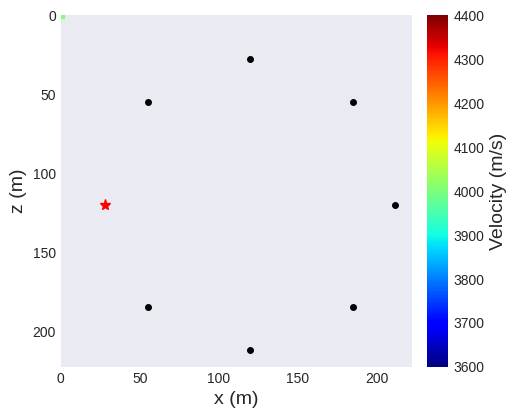

In [39]:
plt.style.use('seaborn-dark')
plt.figure(figsize=(5, 5))

ax = plt.gca()
im = ax.imshow(velmodel, extent=[x[0], x[-1], z[-1], z[0]], aspect=1, cmap='jet')

ax.plot(sx[0], sz[0], 'r*', markersize=8)
ax.plot(sx[1:], sz[1:], 'k.', markersize=8)

plt.xlabel('x (m)', fontsize=14)
plt.xticks(fontsize=10)
plt.ylabel('z (m)', fontsize=14)
plt.yticks(fontsize=10)

ax.xaxis.set_major_locator(plt.MultipleLocator(50))
ax.yaxis.set_major_locator(plt.MultipleLocator(50))

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="6%", pad=0.15)

cbar = plt.colorbar(im, cax=cax)

cbar.set_label('Velocity (m/s)', fontsize=14)
cbar.ax.tick_params(labelsize=10)

plt.savefig("./figs/concretes/velmodel.pdf", format="pdf", bbox_inches='tight')

In [40]:
# Find source location id in X_star

TOLX = 1e-7
TOLZ = 1e-7

sids, _ = np.where(np.logical_and(np.abs(X_starf[0] - sz[0]) < TOLZ, np.abs(X_starf[1] - sx[0]) < TOLX))

print(sids)
print(sids.shape)
print(X_starf[0][sids, 0])
print(X_starf[1][sids, 0])

[5000]
(1,)
[120.]
[28.]


# Preparing SCIANN model object

In [41]:
K.clear_session()

layers = [20] * 4

# Appending source values
velmodelf = velmodel.reshape(-1, 1)[selected_points]
velmodelf = np.append(velmodelf, V0)

px0f = 